<center><span style="font-size:54px;">EduInsight Classifier - Predicting Student Behavior</span></center>


## Importing modules and libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier # type: ignore

c:\Users\abdel\anaconda3\Lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


## Data Preprocessing

In [2]:
# Load the image
image_path = "../Dataset/fatigue/fatigue_10.jpg"
image = cv2.imread(image_path)

# Check the shape of the image
shape = image.shape
print("Image shape:", shape)


Image shape: (720, 1280, 3)


In [3]:
data_path = "Dataset"

# Define image folders
image_folders = [
    "distracted",
    "fatigue",
    "focused",
    "raise_hand",
    "writing_reading",
    "sleeping",
    "using_smartphone"
]

# Load images and labels
X = []
y = []

for label, folder in enumerate(image_folders,  start=0):
    folder_path = os.path.join(data_path, folder)
    image_files = os.listdir(folder_path)
    for img_name in image_files:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
        img = cv2.resize(img, (180, 320))  # Resize to 28x28
        X.append(np.array(img).flatten())
        y.append(label)  # Numerical label
    print("This folder has been loaded:", folder)

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)




This folder has been loaded: distracted
This folder has been loaded: fatigue
This folder has been loaded: focused
This folder has been loaded: raise_hand
This folder has been loaded: writing_reading
This folder has been loaded: sleeping
This folder has been loaded: using_smartphone


This next code is optional, just for us to get data in a dataframe and maybe saving it for later.

In [4]:
##### Create a dictionary with column names and values
columns = [f"pixel_{i}" for i in range(X.shape[1])]

data = {"label": y}
for i, col in enumerate(columns):
    data[col] = X[:, i]

###### Create the DataFrame
df = pd.DataFrame(data)
df.head()

,label,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_57590,pixel_57591,pixel_57592,pixel_57593,pixel_57594,pixel_57595,pixel_57596,pixel_57597,pixel_57598,pixel_57599
0,0,183,184,186,185,185,186,188,187,189,...,65,59,71,73,55,87,77,69,72,74
1,0,202,202,203,203,203,204,204,204,204,...,74,73,81,92,71,103,95,88,88,90
2,0,201,203,202,203,203,204,204,204,205,...,75,71,85,92,69,101,96,90,88,92
3,0,202,203,203,203,203,203,204,204,204,...,78,73,84,89,66,101,95,89,86,84
4,0,202,202,203,202,203,204,204,205,205,...,78,78,85,88,68,102,93,87,89,93


In [5]:
df.duplicated().any()

True

In [6]:
df = df.drop_duplicates(keep='first')
df.duplicated().any()

False

In [7]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("\nX_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (6509, 57600)
y_train shape: (6509,)

X_test shape: (1628, 57600)
y_test shape: (1628,)


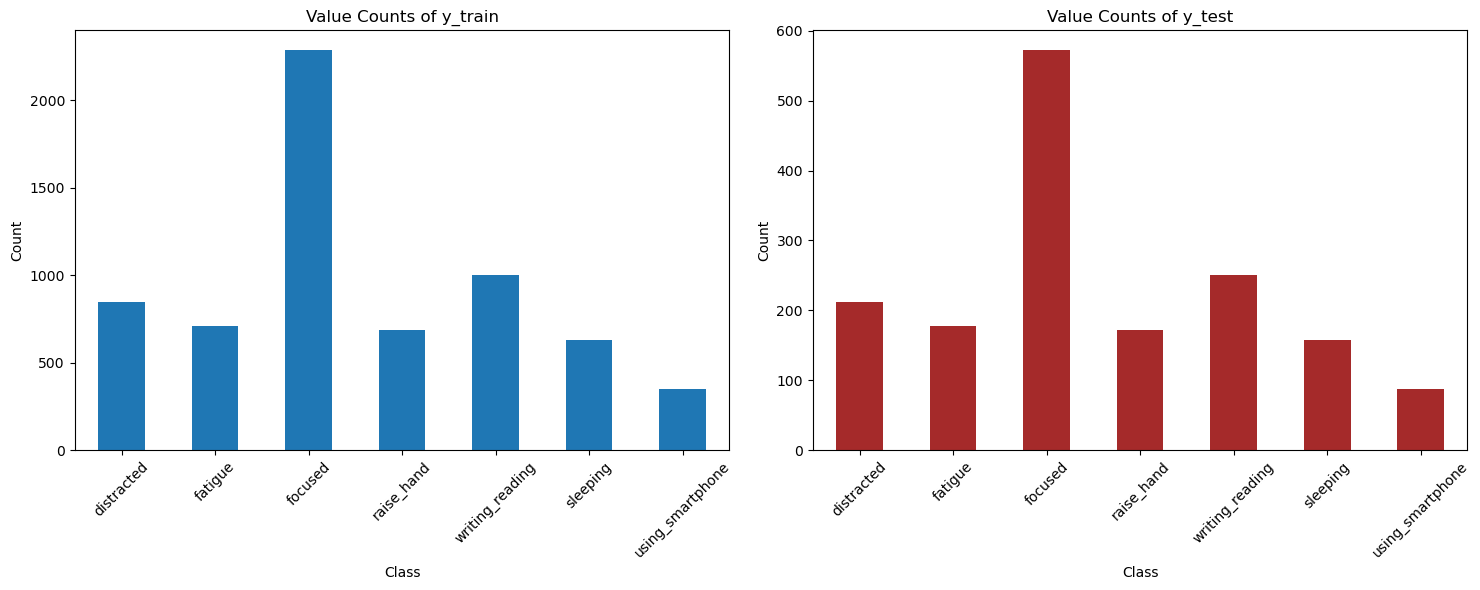

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert y_train and y_test to pandas Series
y_train_series = pd.Series(y_train)
y_test_series = pd.Series(y_test)

# Calculate value counts for both y_train and y_test
y_train_counts = y_train_series.value_counts().sort_index()
y_test_counts = y_test_series.value_counts().sort_index()

# Plotting both value counts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

y_train_counts.plot(kind='bar', ax=ax1)
ax1.set_title('Value Counts of y_train')
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_xticks(range(len(image_folders)))
ax1.set_xticklabels(image_folders, rotation=45)

y_test_counts.plot(kind='bar', ax=ax2, color='brown')
ax2.set_title('Value Counts of y_test')
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_xticks(range(len(image_folders)))
ax2.set_xticklabels(image_folders, rotation=45)

plt.tight_layout()
plt.show()


As you can see, while splitting data into training and testing sets, we tried to keep sae ratio for each behavior to avoid model bias.

## Model Implementation & Evaluation

In [9]:
# Define a function to train and evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'Confusion Matrix:\n{conf_matrix}')

### 1. SVM

In [10]:
svm_model = SVC(kernel='linear')
evaluate_model(svm_model, X_train, X_test, y_train, y_test)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[212   0   0   0   0   0   0]
 [  0 177   0   0   0   0   0]
 [  0   0 572   0   0   0   0]
 [  0   0   0 172   0   0   0]
 [  0   0   0   0 250   0   0]
 [  0   0   0   0   0 158   0]
 [  0   0   0   0   0   0  87]]


In [11]:
# Read the image in grayscale
image = cv2.imread('camera_3.jpg', cv2.IMREAD_GRAYSCALE)

# Resize the image to 180x320 pixels
resized_image = cv2.resize(image, (180, 320))

# Flatten the image
flattened_image = resized_image.flatten()

# Reshape the flattened image to match the input shape of the model
input_image = flattened_image.reshape(1, -1)

# Make a prediction using the sv_model
prediction = svm_model.predict(input_image)

# Print the prediction
print(image_folders[prediction[0]])


fatigue


### 2. Random Forest

In [12]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf_model, X_train, X_test, y_train, y_test)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[212   0   0   0   0   0   0]
 [  0 177   0   0   0   0   0]
 [  0   0 572   0   0   0   0]
 [  0   0   0 172   0   0   0]
 [  0   0   0   0 250   0   0]
 [  0   0   0   0   0 158   0]
 [  0   0   0   0   0   0  87]]


In [13]:
# Read the image in grayscale
image = cv2.imread('camera_2.jpg', cv2.IMREAD_GRAYSCALE)

# Resize the image to 180x320 pixels
resized_image = cv2.resize(image, (180, 320))

# Flatten the image
flattened_image = resized_image.flatten()

# Reshape the flattened image to match the input shape of the model
input_image = flattened_image.reshape(1, -1)

# Make a prediction using the sv_model
prediction = rf_model.predict(input_image)

# Print the prediction
print(image_folders[prediction[0]])


distracted


### 3. KNN

In [14]:
knn_model = KNeighborsClassifier(n_neighbors=3)
evaluate_model(knn_model, X_train, X_test, y_train, y_test)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[212   0   0   0   0   0   0]
 [  0 177   0   0   0   0   0]
 [  0   0 572   0   0   0   0]
 [  0   0   0 172   0   0   0]
 [  0   0   0   0 250   0   0]
 [  0   0   0   0   0 158   0]
 [  0   0   0   0   0   0  87]]


In [15]:
# Read the image in grayscale
image = cv2.imread('camera_3.jpg', cv2.IMREAD_GRAYSCALE)

# Resize the image to 180x320 pixels
resized_image = cv2.resize(image, (180, 320))

# Flatten the image
flattened_image = resized_image.flatten()

# Reshape the flattened image to match the input shape of the model
input_image = flattened_image.reshape(1, -1)

# Make a prediction using the sv_model
prediction = knn_model.predict(input_image)

# Print the prediction
print(image_folders[prediction[0]])


writing_reading


### 4. XGBoost

In [16]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
evaluate_model(xgb_model, X_train, X_test, y_train, y_test)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[212   0   0   0   0   0   0]
 [  0 177   0   0   0   0   0]
 [  0   0 572   0   0   0   0]
 [  0   0   0 172   0   0   0]
 [  0   0   0   0 250   0   0]
 [  0   0   0   0   0 158   0]
 [  0   0   0   0   0   0  87]]


In [ ]:
# Read the image in grayscale
image = cv2.imread('camera_3.jpg', cv2.IMREAD_GRAYSCALE)

# Resize the image to 180x320 pixels
resized_image = cv2.resize(image, (180, 320))

# Flatten the image
flattened_image = resized_image.flatten()

# Reshape the flattened image to match the input shape of the model
input_image = flattened_image.reshape(1, -1)

# Make a prediction using the sv_model
prediction = xgb_model.predict(input_image)

# Print the prediction
print(image_folders[prediction[0]])


writing_reading


### 5. Extra Trees

In [17]:
et_model = ExtraTreesClassifier(n_estimators=100, random_state=42)
evaluate_model(et_model, X_train, X_test, y_train, y_test)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[212   0   0   0   0   0   0]
 [  0 177   0   0   0   0   0]
 [  0   0 572   0   0   0   0]
 [  0   0   0 172   0   0   0]
 [  0   0   0   0 250   0   0]
 [  0   0   0   0   0 158   0]
 [  0   0   0   0   0   0  87]]


In [19]:
# Read the image in grayscale
image = cv2.imread('camera_3.jpg', cv2.IMREAD_GRAYSCALE)

# Resize the image to 180x320 pixels
resized_image = cv2.resize(image, (180, 320))

# Flatten the image
flattened_image = resized_image.flatten()

# Reshape the flattened image to match the input shape of the model
input_image = flattened_image.reshape(1, -1)

# Make a prediction using the sv_model
prediction = et_model.predict(input_image)

# Print the prediction
print(image_folders[prediction[0]])


writing_reading


### 6. CNN

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from keras.utils import to_categorical

# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=7)
y_test_one_hot = to_categorical(y_test, num_classes=7)

# Reshape the data to add the channel dimension (assuming grayscale images)
X_train = X_train.reshape(-1, 180, 320, 1)
X_test = X_test.reshape(-1, 180, 320, 1)

# CNN model definition
cnn_model = Sequential()
cnn_model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(180, 320, 1)))
cnn_model.add(Conv2D(32, kernel_size=3, activation='relu'))
cnn_model.add(Flatten())
cnn_model.add(Dense(7, activation='softmax'))

# Compile and fit the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train_one_hot, validation_data=(X_test, y_test_one_hot), epochs=10)

# Evaluate the model
cnn_accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f'CNN Accuracy: {cnn_accuracy[1]}')


Epoch 1/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.7769 - loss: 1061.2831 - val_accuracy: 0.9957 - val_loss: 0.0329
Epoch 2/10
204/204 ━━━━━━━━━━━━━━━━━━━━ 2354s 12s/step - accuracy: 0.9980 - loss: 0.0121 - val_accuracy: 1.0000 - val_loss: 5.2391e-04
Epoch 3/10
191/204 ━━━━━━━━━━━━━━━━━━━━ 2:21 11s/step - accuracy: 1.0000 - loss: 1.9362e-04

KeyboardInterrupt: 

We don't need to train our CNN model any further, because it appears from the first epoch that we have over-fitting.

## Reflect

This solution is noot ideal nor working, so we will have to change the approach.

We'll try to find a solution to classify online student behavior using another methodology.

 **--> Note:** The code for next time will be provided in the same github repository!